In [55]:
# Force reload of JET3 modules to get latest changes
import sys
import importlib

# Remove JET3 from sys.modules to force reimport
modules_to_reload = [m for m in sys.modules if 'JET3' in m]
for m in modules_to_reload:
    del sys.modules[m]

print(f"Reloaded {len(modules_to_reload)} JET3 modules")

Reloaded 20 JET3 modules


# Meteorology Calibration and UQ

First-pass OLS estimates calibration coefficients, applies corrections, then builds UQ layers from calibrated residuals.

## 1. Import Required Libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from JET3 import load_ECOv002_calval_JET_outputs

plt.style.use("default")
sns.set_palette("husl")

## 2. Load and Prepare Data

In [20]:
df = load_ECOv002_calval_JET_outputs()

# In-situ reference columns
df["insitu_RH"] = df["RH_percentage"]
df["insitu_SM"] = df["SM_surf"]

# Initial error metrics (uncalibrated)
df["Ta_C_error"] = df["Ta_C"] - df["insitu_Ta_C"]
df["Ta_C_error_abs"] = df["Ta_C_error"].abs()

df["RH_error"] = df["RH"] - df["insitu_RH"]
df["RH_error_abs"] = df["RH_error"].abs()

df["SM_error"] = df["SM"] - df["insitu_SM"]
df["SM_error_abs"] = df["SM_error"].abs()

print(f"Dataset shape: {df.shape}")
print(f"Available columns: {len(df.columns)}")
df.head()

Dataset shape: (1065, 188)
Available columns: 188


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_62534/2241426990.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["insitu_SM"] = df["SM_surf"]
/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_62534/2241426990.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["Ta_C_error"] = df["Ta_C"] - df["insitu_Ta_C"]
/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_62534/2241426990.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many tim

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,ET_canopy_inst_kg_m2_s,WUE,AuxiliaryNWP,insitu_SM,Ta_C_error,Ta_C_error_abs,RH_error,RH_error_abs,SM_error,SM_error_abs
0,0,US-NC3,ENF,Cfa,270.34520,78.53355,392.85184,307.02197,487.383423,118.91628,...,0.000109,1.943556,NaN,0.201566,0.857850,0.857850,-0.076633,0.076633,-0.009207,0.009207
1,1,US-Mi3,CVM,Dfb,232.14160,229.20093,640.11847,375.08930,106.825577,167.91946,...,0.000111,2.421845,NaN,0.420438,-2.004618,2.004618,NaN,NaN,-0.127222,0.127222
2,2,US-Mi3,CVM,Dfb,356.35574,335.23154,625.66170,284.68625,NaN,132.93634,...,0.000044,5.670131,NaN,0.406938,-4.084138,4.084138,NaN,NaN,0.026498,0.026498
3,3,US-Mi3,CVM,Dfb,332.93840,326.68680,624.25433,251.41449,178.827545,141.13242,...,0.000049,6.158837,NaN,0.398036,-1.106204,1.106204,NaN,NaN,-0.006793,0.006793
4,4,US-Mi3,CVM,Dfb,286.85403,237.21654,511.08218,228.52017,154.791626,114.80941,...,0.000058,4.846558,NaN,0.397494,-1.053609,1.053609,NaN,NaN,-0.063624,0.063624


## 3. Define Independent Variables

In [21]:
INPUT_VARIABLES = [
    "NDVI",
    "ST_C",
    "SZA_deg",
    "albedo",
    "canopy_height_meters",
    "elevation_m",
    "emissivity",
    "wind_speed_mps",
]

vars_in_df = [v for v in INPUT_VARIABLES if v in df.columns]
missing_vars = [v for v in INPUT_VARIABLES if v not in df.columns]

print(f"Independent Variables Available: {len(vars_in_df)}")
print(f"  {', '.join(vars_in_df)}")
if missing_vars:
    print(f"Missing Variables: {', '.join(missing_vars)}")

Independent Variables Available: 8
  NDVI, ST_C, SZA_deg, albedo, canopy_height_meters, elevation_m, emissivity, wind_speed_mps


## 4. Exploratory Data Analysis

ERROR METRICS SUMMARY STATISTICS
       Ta_C_error  RH_error  SM_error
count   1048.0000 1027.0000  833.0000
mean       0.9463    0.1138    0.0301
std        2.5847    0.1186    0.0937
min       -8.1564   -0.3955   -0.5442
25%       -0.6063    0.0384   -0.0094
50%        0.7325    0.1349    0.0338
75%        2.2244    0.2068    0.0727
max       14.9174    0.4845    0.6013



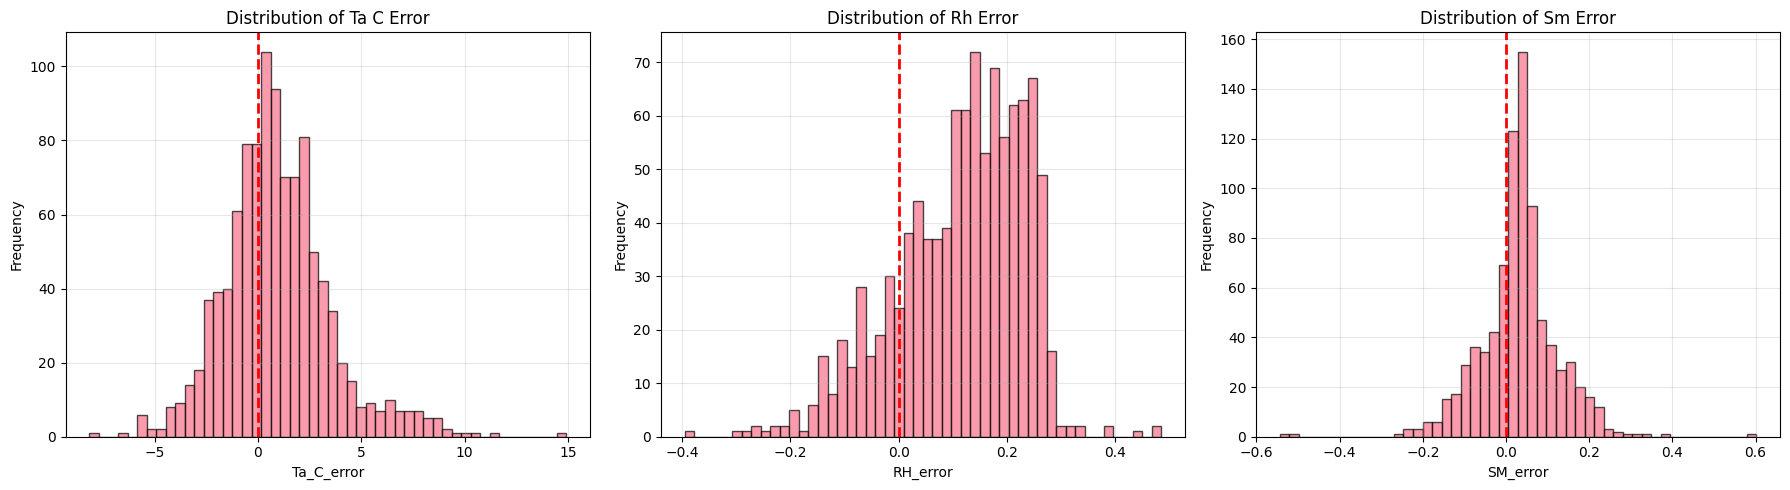

In [22]:
error_metrics = ["Ta_C_error", "RH_error", "SM_error"]
error_summary = df[error_metrics].describe()

print("=" * 80)
print("ERROR METRICS SUMMARY STATISTICS")
print("=" * 80)
print(error_summary.to_string(float_format=lambda x: f"{x:.4f}"))
print()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, metric in zip(axes, error_metrics):
    data = df[metric].dropna()
    ax.hist(data, bins=50, alpha=0.7, edgecolor="black")
    ax.axvline(0, color="red", linestyle="--", linewidth=2)
    ax.set_xlabel(metric)
    ax.set_ylabel("Frequency")
    ax.set_title(f"Distribution of {metric.replace('_', ' ').title()}")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. First-Pass OLS Regression (Calibration)

In [23]:
def perform_ols_regression(df, target_col, input_vars):
    predictor_vars = [v for v in input_vars if v in df.columns]
    X = df[predictor_vars].dropna()
    y = df.loc[X.index, target_col].dropna()

    common_idx = X.index.intersection(y.index)
    X = X.loc[common_idx]
    y = y.loc[common_idx]

    ols_model = LinearRegression()
    ols_model.fit(X, y)

    X_sm = sm.add_constant(X, has_constant="add")
    ols_inference = sm.OLS(y, X_sm).fit()

    coef_df = pd.DataFrame({
        "Variable": predictor_vars,
        "Coefficient": ols_model.coef_,
        "p_value": ols_inference.pvalues.reindex(predictor_vars).values,
    }).sort_values("Coefficient", key=lambda x: x.abs(), ascending=False)

    y_pred = ols_model.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)

    vif_vals = []
    for i, col in enumerate(X.columns):
        vif_vals.append((col, variance_inflation_factor(X.values, i)))
    vif_df = pd.DataFrame(vif_vals, columns=["Variable", "VIF"]).sort_values("VIF", ascending=False)

    return {
        "model": ols_model,
        "inference": ols_inference,
        "coefficients": coef_df,
        "vif": vif_df,
        "X": X,
        "y": y,
        "y_pred": y_pred,
        "r2": r2,
        "rmse": rmse,
        "mae": mae,
        "predictor_vars": predictor_vars,
    }


ta_cal = perform_ols_regression(df, "Ta_C_error", INPUT_VARIABLES)
rh_cal = perform_ols_regression(df, "RH_error", INPUT_VARIABLES)
sm_cal = perform_ols_regression(df, "SM_error", INPUT_VARIABLES)

for label, results in [("Ta_C", ta_cal), ("RH", rh_cal), ("SM", sm_cal)]:
    print("=" * 80)
    print(f"CALIBRATION MODEL: {label}")
    print("=" * 80)
    print(f"R² = {results['r2']:.4f}  RMSE = {results['rmse']:.4f}  MAE = {results['mae']:.4f}")
    print(results["coefficients"].to_string(index=False, float_format=lambda v: f"{v:.6f}"))
    print()

CALIBRATION MODEL: Ta_C
R² = 0.2973  RMSE = 2.1664  MAE = 1.6223
            Variable  Coefficient  p_value
          emissivity    -5.516014 0.295179
                NDVI     1.901556 0.000012
              albedo     1.461571 0.248946
      wind_speed_mps    -0.074569 0.139483
             SZA_deg    -0.043550 0.000000
canopy_height_meters    -0.033969 0.001008
         elevation_m     0.002203 0.000000
                ST_C     0.000150 0.984830

CALIBRATION MODEL: RH
R² = 0.2938  RMSE = 0.0996  MAE = 0.0743
            Variable  Coefficient  p_value
          emissivity     0.627991 0.013898
                NDVI    -0.180705 0.000000
              albedo    -0.045821 0.433552
      wind_speed_mps     0.009642 0.000048
                ST_C     0.003984 0.000000
canopy_height_meters     0.002941 0.000000
             SZA_deg     0.001061 0.000243
         elevation_m     0.000004 0.543059

CALIBRATION MODEL: SM
R² = 0.0577  RMSE = 0.0910  MAE = 0.0622
            Variable  Coefficient

## 6. Apply Calibration Coefficients

In [24]:
def calibrate_variable(df, var_col, insitu_col, results, out_col):
    X_full = df[results["predictor_vars"]].copy()
    X_clean = X_full.dropna()
    pred_error = pd.Series(results["model"].predict(X_clean), index=X_clean.index)

    df[f"{var_col}_pred_error"] = np.nan
    df.loc[pred_error.index, f"{var_col}_pred_error"] = pred_error

    df[out_col] = df[var_col] - df[f"{var_col}_pred_error"]
    df[f"{out_col}_error"] = df[out_col] - df[insitu_col]
    df[f"{out_col}_error_abs"] = df[f"{out_col}_error"].abs()


calibrate_variable(df, "Ta_C", "insitu_Ta_C", ta_cal, "Ta_C_cal")
calibrate_variable(df, "RH", "insitu_RH", rh_cal, "RH_cal")
calibrate_variable(df, "SM", "insitu_SM", sm_cal, "SM_cal")

print("Calibrated columns: Ta_C_cal, RH_cal, SM_cal")

Calibrated columns: Ta_C_cal, RH_cal, SM_cal


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_62534/302114528.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{var_col}_pred_error"] = np.nan
/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_62534/302114528.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[out_col] = df[var_col] - df[f"{var_col}_pred_error"]
/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_62534/302114528.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert`

## 7. Validate Calibrated Data

In [25]:
def metrics_table(df, obs_col, est_col, label):
    aligned = pd.concat([df[obs_col], df[est_col]], axis=1).dropna()
    aligned.columns = ["obs", "est"]
    return {
        "Target": label,
        "R2": r2_score(aligned["obs"], aligned["est"]),
        "RMSE": np.sqrt(mean_squared_error(aligned["obs"], aligned["est"])),
        "MAE": mean_absolute_error(aligned["obs"], aligned["est"]),
        "N": len(aligned),
    }

rows = []
rows.append(metrics_table(df, "insitu_Ta_C", "Ta_C", "Ta_C (raw)"))
rows.append(metrics_table(df, "insitu_Ta_C", "Ta_C_cal", "Ta_C (calibrated)"))
rows.append(metrics_table(df, "insitu_RH", "RH", "RH (raw)"))
rows.append(metrics_table(df, "insitu_RH", "RH_cal", "RH (calibrated)"))
rows.append(metrics_table(df, "insitu_SM", "SM", "SM (raw)"))
rows.append(metrics_table(df, "insitu_SM", "SM_cal", "SM (calibrated)"))

metrics_df = pd.DataFrame(rows)
print(metrics_df.to_string(index=False, float_format=lambda v: f"{v:.4f}"))

           Target     R2   RMSE    MAE    N
       Ta_C (raw) 0.8876 2.7514 2.0251 1048
Ta_C (calibrated) 0.9304 2.1664 1.6223 1046
         RH (raw) 0.2804 0.1643 0.1425 1027
  RH (calibrated) 0.7355 0.0996 0.0743 1025
         SM (raw) 0.3531 0.0983 0.0727  833
  SM (calibrated) 0.4477 0.0910 0.0622  831


## 8. Correlation Analysis on Calibrated Data

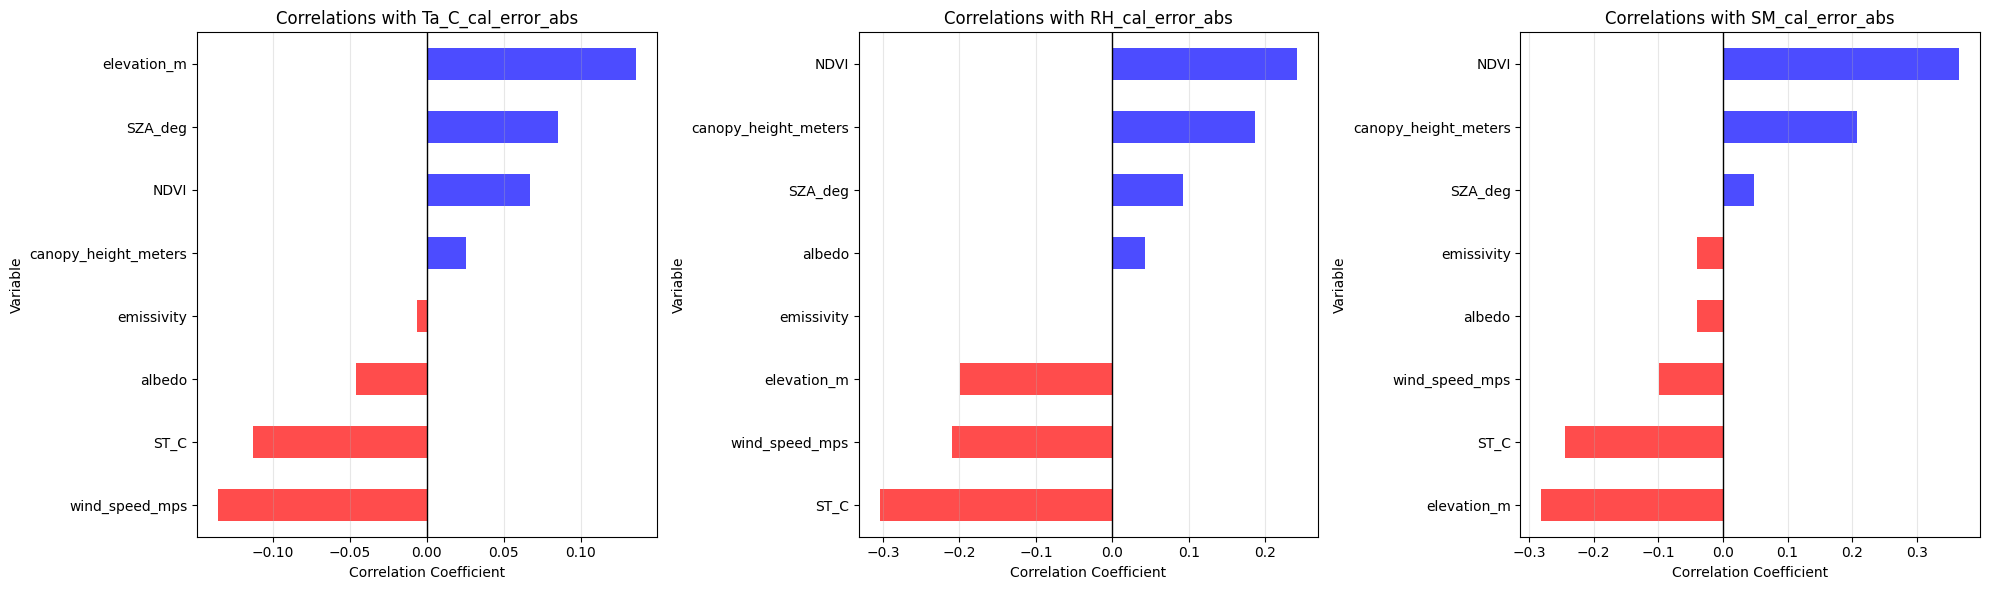

In [26]:
def calculate_correlations(df, target_col, input_vars):
    vars_in_df = [v for v in input_vars if v in df.columns]
    numeric_vars = df[vars_in_df].select_dtypes(include=[np.number]).columns.tolist()

    rows = []
    for var in numeric_vars:
        pair = df[[var, target_col]].dropna()
        if len(pair) < 3:
            continue
        r, p = pearsonr(pair[var], pair[target_col])
        if not (np.isfinite(r) and np.isfinite(p)):
            continue
        rows.append({
            "variable": var,
            "correlation": r,
            "r_square": r ** 2,
            "p_value": p,
            "n": len(pair),
        })

    return (
        pd.DataFrame(rows)
        .sort_values(by="correlation", key=lambda s: s.abs(), ascending=False)
        .set_index("variable")
    )

cal_target_cols = ["Ta_C_cal_error_abs", "RH_cal_error_abs", "SM_cal_error_abs"]
cal_corr = {t: calculate_correlations(df, t, INPUT_VARIABLES) for t in cal_target_cols}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for ax, target in zip(axes, cal_target_cols):
    correlations = cal_corr[target]["correlation"].sort_values()
    colors = ["red" if c < 0 else "blue" for c in correlations]
    correlations.plot(kind="barh", ax=ax, color=colors, alpha=0.7)
    ax.set_xlabel("Correlation Coefficient")
    ax.set_ylabel("Variable")
    ax.set_title(f"Correlations with {target}")
    ax.grid(True, axis="x", alpha=0.3)
    ax.axvline(0, color="black", linewidth=1)

plt.tight_layout()
plt.show()

## 9. Second-Pass OLS Regression (UQ for Absolute Error)

NOTE: We predict ABSOLUTE error magnitude so these coefficients can be applied to remote sensing data without in-situ.

In [27]:
ta_uq_model = perform_ols_regression(df, "Ta_C_cal_error_abs", INPUT_VARIABLES)
rh_uq_model = perform_ols_regression(df, "RH_cal_error_abs", INPUT_VARIABLES)
sm_uq_model = perform_ols_regression(df, "SM_cal_error_abs", INPUT_VARIABLES)

for label, results in [("Ta_C", ta_uq_model), ("RH", rh_uq_model), ("SM", sm_uq_model)]:
    print("=" * 80)
    print(f"UQ MODEL (Predicting Absolute Error): {label}")
    print("=" * 80)
    print(f"R² = {results['r2']:.4f}  RMSE = {results['rmse']:.4f}  MAE = {results['mae']:.4f}")
    print()

UQ MODEL (Predicting Absolute Error): Ta_C
R² = 0.0789  RMSE = 1.3780  MAE = 1.0622

UQ MODEL (Predicting Absolute Error): RH
R² = 0.1419  RMSE = 0.0615  MAE = 0.0437

UQ MODEL (Predicting Absolute Error): SM
R² = 0.1757  RMSE = 0.0603  MAE = 0.0418



## 10. Generate UQ Layers for Calibrated Data

In [28]:
def build_uq_layers(results, data, alpha=0.05, bin_count=10):
    predictor_vars = results["predictor_vars"]
    X = data[predictor_vars].copy().dropna()
    if X.empty:
        return pd.DataFrame(index=data.index)

    X_sm = sm.add_constant(X, has_constant="add")
    pred = results["inference"].get_prediction(X_sm)
    pred_summary = pred.summary_frame(alpha=alpha)

    layers = pd.DataFrame(index=X.index)
    layers["error_mean"] = pred_summary["mean"]
    layers["error_se"] = pred_summary["mean_se"]
    layers["error_pi_lower"] = pred_summary["obs_ci_lower"]
    layers["error_pi_upper"] = pred_summary["obs_ci_upper"]

    train_pred = pd.Series(results["y_pred"], index=results["y"].index)
    train_resid = results["y"] - results["y_pred"]

    try:
        bin_edges = pd.qcut(train_pred, q=bin_count, retbins=True, duplicates="drop")[1]
    except ValueError:
        quantiles = np.linspace(0, 1, min(bin_count, len(train_pred)))
        bin_edges = np.unique(np.quantile(train_pred, quantiles))

    if len(bin_edges) < 3:
        global_sigma = np.nanstd(train_resid)
        layers["error_sigma_empirical"] = global_sigma
    else:
        train_bins = pd.cut(train_pred, bins=bin_edges, include_lowest=True, duplicates="drop")
        bin_sigma = train_resid.groupby(train_bins).std()
        pred_bins = pd.cut(layers["error_mean"], bins=bin_edges, include_lowest=True, duplicates="drop")
        layers["error_sigma_empirical"] = pred_bins.map(bin_sigma).astype(float)
        layers["error_sigma_empirical"] = layers["error_sigma_empirical"].fillna(np.nanstd(train_resid))

    z = 1.0  # 1-sigma
    layers["error_pi_emp_lower"] = layers["error_mean"] - z * layers["error_sigma_empirical"]
    layers["error_pi_emp_upper"] = layers["error_mean"] + z * layers["error_sigma_empirical"]

    return layers


def prefix_columns(frame, prefix):
    return frame.add_prefix(f"{prefix}_")


ta_uq = build_uq_layers(ta_uq_model, df)
rh_uq = build_uq_layers(rh_uq_model, df)
sm_uq = build_uq_layers(sm_uq_model, df)

uq_layers_cal = pd.concat(
    [
        prefix_columns(ta_uq, "Ta_C"),
        prefix_columns(rh_uq, "RH"),
        prefix_columns(sm_uq, "SM"),
    ],
    axis=1,
    join="outer",
)

uq_table = pd.DataFrame(
    [
        {"data_layer": "Ta_C_cal", "uq_layer_1sigma": "Ta_C_error_sigma_empirical"},
        {"data_layer": "RH_cal", "uq_layer_1sigma": "RH_error_sigma_empirical"},
        {"data_layer": "SM_cal", "uq_layer_1sigma": "SM_error_sigma_empirical"},
    ]
)

print("UQ layer columns:")
print(uq_layers_cal.columns.tolist())
print("\nData layers with 1-sigma UQ columns:")
print(uq_table.to_string(index=False))

UQ layer columns:
['Ta_C_error_mean', 'Ta_C_error_se', 'Ta_C_error_pi_lower', 'Ta_C_error_pi_upper', 'Ta_C_error_sigma_empirical', 'Ta_C_error_pi_emp_lower', 'Ta_C_error_pi_emp_upper', 'RH_error_mean', 'RH_error_se', 'RH_error_pi_lower', 'RH_error_pi_upper', 'RH_error_sigma_empirical', 'RH_error_pi_emp_lower', 'RH_error_pi_emp_upper', 'SM_error_mean', 'SM_error_se', 'SM_error_pi_lower', 'SM_error_pi_upper', 'SM_error_sigma_empirical', 'SM_error_pi_emp_lower', 'SM_error_pi_emp_upper']

Data layers with 1-sigma UQ columns:
data_layer            uq_layer_1sigma
  Ta_C_cal Ta_C_error_sigma_empirical
    RH_cal   RH_error_sigma_empirical
    SM_cal   SM_error_sigma_empirical


## 11. Visualization of Calibration Impact

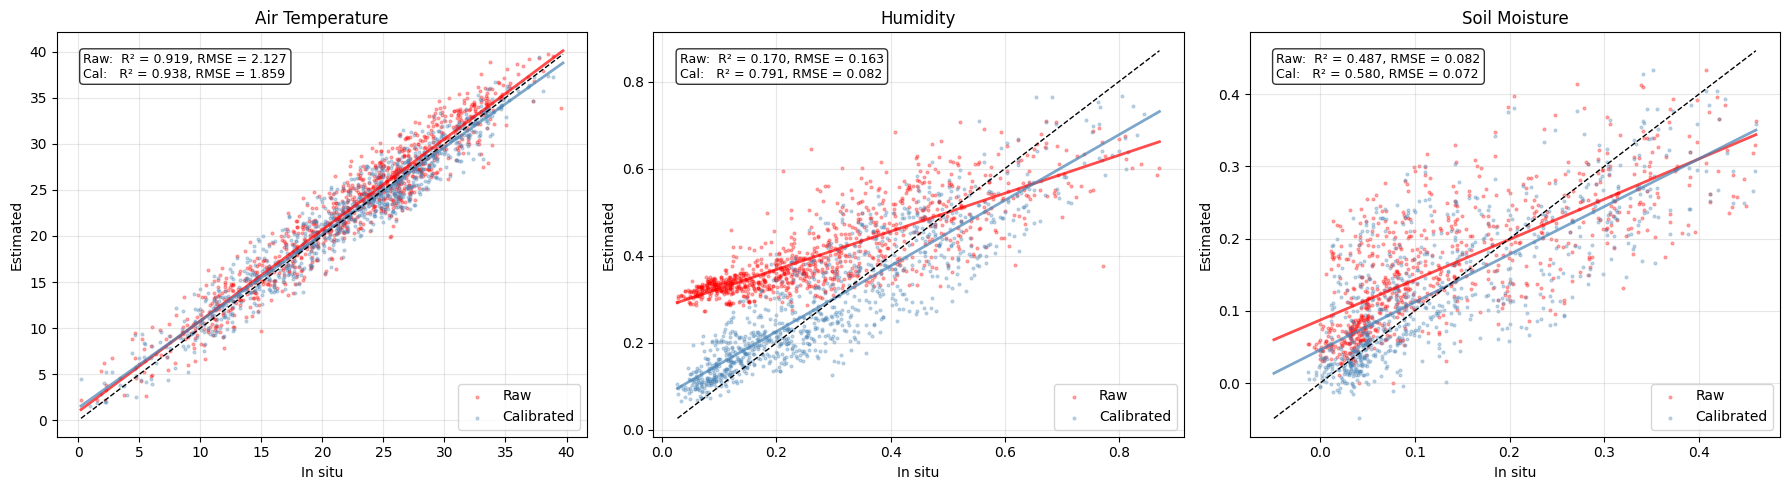

In [29]:
# Before/after: observed vs estimated
compare_specs = [
    ("insitu_Ta_C", "Ta_C", "Ta_C_cal", "Air Temperature"),
    ("insitu_RH", "RH", "RH_cal", "Humidity"),
    ("insitu_SM", "SM", "SM_cal", "Soil Moisture"),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (obs_col, raw_col, cal_col, label) in zip(axes, compare_specs):
    raw = pd.concat([df[obs_col], df[raw_col]], axis=1).dropna()
    cal = pd.concat([df[obs_col], df[cal_col]], axis=1).dropna()
    
    # Remove outliers using IQR method on absolute error and observed/estimated values
    raw["abs_error"] = (raw[raw_col] - raw[obs_col]).abs()
    Q1_raw_err = raw["abs_error"].quantile(0.25)
    Q3_raw_err = raw["abs_error"].quantile(0.75)
    IQR_raw_err = Q3_raw_err - Q1_raw_err
    
    Q1_raw_obs = raw[obs_col].quantile(0.25)
    Q3_raw_obs = raw[obs_col].quantile(0.75)
    IQR_raw_obs = Q3_raw_obs - Q1_raw_obs
    
    Q1_raw_est = raw[raw_col].quantile(0.25)
    Q3_raw_est = raw[raw_col].quantile(0.75)
    IQR_raw_est = Q3_raw_est - Q1_raw_est
    
    raw = raw[
        (raw["abs_error"] >= Q1_raw_err - 1.5 * IQR_raw_err) & (raw["abs_error"] <= Q3_raw_err + 1.5 * IQR_raw_err) &
        (raw[obs_col] >= Q1_raw_obs - 1.5 * IQR_raw_obs) & (raw[obs_col] <= Q3_raw_obs + 1.5 * IQR_raw_obs) &
        (raw[raw_col] >= Q1_raw_est - 1.5 * IQR_raw_est) & (raw[raw_col] <= Q3_raw_est + 1.5 * IQR_raw_est)
    ]
    
    cal["abs_error"] = (cal[cal_col] - cal[obs_col]).abs()
    Q1_cal_err = cal["abs_error"].quantile(0.25)
    Q3_cal_err = cal["abs_error"].quantile(0.75)
    IQR_cal_err = Q3_cal_err - Q1_cal_err
    
    Q1_cal_obs = cal[obs_col].quantile(0.25)
    Q3_cal_obs = cal[obs_col].quantile(0.75)
    IQR_cal_obs = Q3_cal_obs - Q1_cal_obs
    
    Q1_cal_est = cal[cal_col].quantile(0.25)
    Q3_cal_est = cal[cal_col].quantile(0.75)
    IQR_cal_est = Q3_cal_est - Q1_cal_est
    
    cal = cal[
        (cal["abs_error"] >= Q1_cal_err - 1.5 * IQR_cal_err) & (cal["abs_error"] <= Q3_cal_err + 1.5 * IQR_cal_err) &
        (cal[obs_col] >= Q1_cal_obs - 1.5 * IQR_cal_obs) & (cal[obs_col] <= Q3_cal_obs + 1.5 * IQR_cal_obs) &
        (cal[cal_col] >= Q1_cal_est - 1.5 * IQR_cal_est) & (cal[cal_col] <= Q3_cal_est + 1.5 * IQR_cal_est)
    ]
    
    # Scatter points
    ax.scatter(raw[obs_col], raw[raw_col], s=4, alpha=0.3, label="Raw", color="red")
    ax.scatter(cal[obs_col], cal[cal_col], s=4, alpha=0.3, label="Calibrated", color="steelblue")
    
    # Calculate metrics and fit regression lines
    raw_r2 = r2_score(raw[obs_col], raw[raw_col])
    raw_rmse = np.sqrt(mean_squared_error(raw[obs_col], raw[raw_col]))
    cal_r2 = r2_score(cal[obs_col], cal[cal_col])
    cal_rmse = np.sqrt(mean_squared_error(cal[obs_col], cal[cal_col]))
    
    # Fit regression lines
    raw_coef = np.polyfit(raw[obs_col], raw[raw_col], 1)
    cal_coef = np.polyfit(cal[obs_col], cal[cal_col], 1)
    
    # Plot regression lines
    min_lim = min(raw[obs_col].min(), raw[raw_col].min(), cal[cal_col].min())
    max_lim = max(raw[obs_col].max(), raw[raw_col].max(), cal[cal_col].max())
    x_line = np.array([min_lim, max_lim])
    ax.plot(x_line, raw_coef[0] * x_line + raw_coef[1], "r-", linewidth=2, alpha=0.7)
    ax.plot(x_line, cal_coef[0] * x_line + cal_coef[1], color="steelblue", linewidth=2, alpha=0.7)
    ax.plot([min_lim, max_lim], [min_lim, max_lim], "k--", linewidth=1)
    
    # Add text with metrics
    textstr = f"Raw:  R² = {raw_r2:.3f}, RMSE = {raw_rmse:.3f}\nCal:   R² = {cal_r2:.3f}, RMSE = {cal_rmse:.3f}"
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_title(label)
    ax.set_xlabel("In situ")
    ax.set_ylabel("Estimated")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

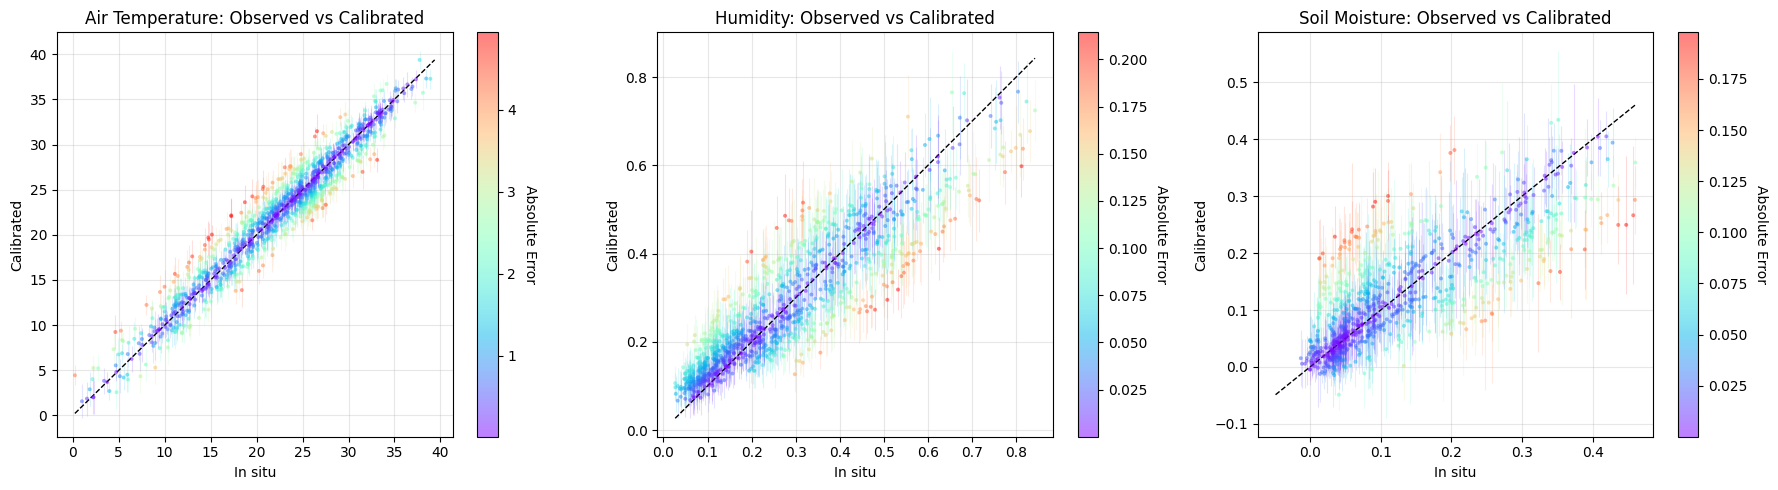

In [30]:
# Error bars on calibrated estimates with 1-sigma UQ
errorbar_specs = [
    ("insitu_Ta_C", "Ta_C_cal", "Ta_C_error_sigma_empirical", "Air Temperature"),
    ("insitu_RH", "RH_cal", "RH_error_sigma_empirical", "Humidity"),
    ("insitu_SM", "SM_cal", "SM_error_sigma_empirical", "Soil Moisture"),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for col_idx, (obs_col, cal_col, uq_col, label) in enumerate(errorbar_specs):
    aligned = pd.concat([df[obs_col], df[cal_col], uq_layers_cal[uq_col]], axis=1, join="inner").dropna()
    aligned.columns = ["obs", "cal", "sigma"]
    
    # Calculate absolute error for coloring
    aligned["abs_error"] = (aligned["cal"] - aligned["obs"]).abs()
    
    # Remove outliers using IQR method on absolute error, obs, and cal values
    Q1_err = aligned["abs_error"].quantile(0.25)
    Q3_err = aligned["abs_error"].quantile(0.75)
    IQR_err = Q3_err - Q1_err
    
    Q1_obs = aligned["obs"].quantile(0.25)
    Q3_obs = aligned["obs"].quantile(0.75)
    IQR_obs = Q3_obs - Q1_obs
    
    Q1_cal = aligned["cal"].quantile(0.25)
    Q3_cal = aligned["cal"].quantile(0.75)
    IQR_cal = Q3_cal - Q1_cal
    
    aligned = aligned[
        (aligned["abs_error"] >= Q1_err - 1.5 * IQR_err) & (aligned["abs_error"] <= Q3_err + 1.5 * IQR_err) &
        (aligned["obs"] >= Q1_obs - 1.5 * IQR_obs) & (aligned["obs"] <= Q3_obs + 1.5 * IQR_obs) &
        (aligned["cal"] >= Q1_cal - 1.5 * IQR_cal) & (aligned["cal"] <= Q3_cal + 1.5 * IQR_cal)
    ]

    # Plot error bars with color mapping (behind points)
    for idx in aligned.index:
        # Get color from colormap based on absolute error
        norm = plt.Normalize(vmin=aligned["abs_error"].min(), vmax=aligned["abs_error"].max())
        cmap = plt.cm.rainbow
        color = cmap(norm(aligned.loc[idx, "abs_error"]))
        
        axes[col_idx].errorbar(
            aligned.loc[idx, "obs"],
            aligned.loc[idx, "cal"],
            yerr=aligned.loc[idx, "sigma"],
            fmt="none",
            ecolor=color,
            elinewidth=0.8,
            capsize=0,
            alpha=0.15,
            zorder=1,
        )
    
    # Scatter plot colored by absolute error (on top of error bars)
    scatter = axes[col_idx].scatter(
        aligned["obs"],
        aligned["cal"],
        c=aligned["abs_error"],
        s=8,
        alpha=0.5,
        cmap="rainbow",
        edgecolors="none",
        zorder=3,
    )
    
    min_lim = min(aligned["obs"].min(), aligned["cal"].min())
    max_lim = max(aligned["obs"].max(), aligned["cal"].max())
    axes[col_idx].plot([min_lim, max_lim], [min_lim, max_lim], "k--", linewidth=1)
    axes[col_idx].set_title(f"{label}: Observed vs Calibrated")
    axes[col_idx].set_xlabel("In situ")
    axes[col_idx].set_ylabel("Calibrated")
    axes[col_idx].grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[col_idx])
    cbar.set_label("Absolute Error", rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

## 12. Calibration and UQ Coefficient Report

In [34]:
# Generate Raw UQ models - predict absolute error of raw (uncalibrated) values
ta_raw_uq_model = perform_ols_regression(df, "Ta_C_error_abs", INPUT_VARIABLES)
rh_raw_uq_model = perform_ols_regression(df, "RH_error_abs", INPUT_VARIABLES)
sm_raw_uq_model = perform_ols_regression(df, "SM_error_abs", INPUT_VARIABLES)

for label, results in [("Ta_C", ta_raw_uq_model), ("RH", rh_raw_uq_model), ("SM", sm_raw_uq_model)]:
    print("=" * 80)
    print(f"RAW UQ MODEL (Predicting Absolute Error of Uncalibrated Values): {label}")
    print("=" * 80)
    print(f"R² = {results['r2']:.4f}  RMSE = {results['rmse']:.4f}  MAE = {results['mae']:.4f}")
    print()

# Build UQ layers for raw (uncalibrated) data
ta_raw_uq = build_uq_layers(ta_raw_uq_model, df)
rh_raw_uq = build_uq_layers(rh_raw_uq_model, df)
sm_raw_uq = build_uq_layers(sm_raw_uq_model, df)

uq_layers_raw = pd.concat(
    [
        prefix_columns(ta_raw_uq, "Ta_C_raw"),
        prefix_columns(rh_raw_uq, "RH_raw"),
        prefix_columns(sm_raw_uq, "SM_raw"),
    ],
    axis=1,
    join="outer",
)

raw_uq_table = pd.DataFrame(
    [
        {"data_layer": "Ta_C", "uq_layer_1sigma": "Ta_C_raw_error_sigma_empirical"},
        {"data_layer": "RH", "uq_layer_1sigma": "RH_raw_error_sigma_empirical"},
        {"data_layer": "SM", "uq_layer_1sigma": "SM_raw_error_sigma_empirical"},
    ]
)

print("Raw UQ layer columns:")
print(uq_layers_raw.columns.tolist())
print("\nData layers with 1-sigma Raw UQ columns:")
print(raw_uq_table.to_string(index=False))

RAW UQ MODEL (Predicting Absolute Error of Uncalibrated Values): Ta_C
R² = 0.2660  RMSE = 1.5964  MAE = 1.2074

RAW UQ MODEL (Predicting Absolute Error of Uncalibrated Values): RH
R² = 0.2539  RMSE = 0.0707  MAE = 0.0549

RAW UQ MODEL (Predicting Absolute Error of Uncalibrated Values): SM
R² = 0.1275  RMSE = 0.0619  MAE = 0.0434

Raw UQ layer columns:
['Ta_C_raw_error_mean', 'Ta_C_raw_error_se', 'Ta_C_raw_error_pi_lower', 'Ta_C_raw_error_pi_upper', 'Ta_C_raw_error_sigma_empirical', 'Ta_C_raw_error_pi_emp_lower', 'Ta_C_raw_error_pi_emp_upper', 'RH_raw_error_mean', 'RH_raw_error_se', 'RH_raw_error_pi_lower', 'RH_raw_error_pi_upper', 'RH_raw_error_sigma_empirical', 'RH_raw_error_pi_emp_lower', 'RH_raw_error_pi_emp_upper', 'SM_raw_error_mean', 'SM_raw_error_se', 'SM_raw_error_pi_lower', 'SM_raw_error_pi_upper', 'SM_raw_error_sigma_empirical', 'SM_raw_error_pi_emp_lower', 'SM_raw_error_pi_emp_upper']

Data layers with 1-sigma Raw UQ columns:
data_layer                uq_layer_1sigma
      T

## 11a. UQ Models for Raw/Uncalibrated Data

Generate uncertainty quantification coefficients that predict absolute error magnitude for raw sensor values (without applying calibration correction first). These provide uncertainty estimates directly applicable to uncalibrated remote sensing estimates.

In [36]:
print("=" * 100)
print("CALIBRATION COEFFICIENTS REPORT")
print("=" * 100)
print("\nThese coefficients are used to correct raw estimates by predicting their errors.")
print("Formula: corrected_value = raw_value - predicted_error")
print("Where: predicted_error = intercept + sum(coefficient_i * predictor_i)")
print("\n")

for var_name, results in [("Air Temperature (Ta_C)", ta_cal), ("Humidity (RH)", rh_cal), ("Soil Moisture (SM)", sm_cal)]:
    print("-" * 100)
    print(f"{var_name} CALIBRATION")
    print("-" * 100)
    print(f"Model Performance: R² = {results['r2']:.4f}, RMSE = {results['rmse']:.4f}, MAE = {results['mae']:.4f}")
    print(f"Intercept: {results['model'].intercept_:.6f}")
    print("\nCoefficients:")
    for var, coef, pval in zip(results['coefficients']['Variable'], 
                                results['coefficients']['Coefficient'], 
                                results['coefficients']['p_value']):
        sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
        print(f"  {var:30s}: {coef:12.6f}  (p={pval:.4f}) {sig}")
    print()

print("\n" + "=" * 100)
print("UNCERTAINTY QUANTIFICATION (UQ) COEFFICIENTS - CALIBRATED DATA")
print("=" * 100)
print("\nThese coefficients predict the expected absolute error (1-sigma uncertainty) of calibrated estimates.")
print("CRITICAL: These use ONLY remote sensing inputs, so they can be applied operationally without in-situ data.")
print("Formula: predicted_uncertainty = intercept + sum(coefficient_i * predictor_i)")
print("\n")

for var_name, results in [("Air Temperature (Ta_C)", ta_uq_model), ("Humidity (RH)", rh_uq_model), ("Soil Moisture (SM)", sm_uq_model)]:
    print("-" * 100)
    print(f"{var_name} UQ MODEL (Predicting Absolute Error of Calibrated Values)")
    print("-" * 100)
    print(f"Model Performance: R² = {results['r2']:.4f}, RMSE = {results['rmse']:.4f}, MAE = {results['mae']:.4f}")
    print(f"Intercept: {results['model'].intercept_:.6f}")
    print("\nCoefficients:")
    for var, coef, pval in zip(results['coefficients']['Variable'], 
                                results['coefficients']['Coefficient'], 
                                results['coefficients']['p_value']):
        sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
        print(f"  {var:30s}: {coef:12.6f}  (p={pval:.4f}) {sig}")
    print()

print("\n" + "=" * 100)
print("UNCERTAINTY QUANTIFICATION (UQ) COEFFICIENTS - RAW/UNCALIBRATED DATA")
print("=" * 100)
print("\nThese coefficients predict the expected absolute error (1-sigma uncertainty) of raw/uncalibrated estimates.")
print("These can be used when you want uncertainty estimates WITHOUT applying the calibration correction.")
print("Formula: predicted_uncertainty = intercept + sum(coefficient_i * predictor_i)")
print("\n")

for var_name, results in [("Air Temperature (Ta_C)", ta_raw_uq_model), ("Humidity (RH)", rh_raw_uq_model), ("Soil Moisture (SM)", sm_raw_uq_model)]:
    print("-" * 100)
    print(f"{var_name} RAW UQ MODEL (Predicting Absolute Error of Uncalibrated Values)")
    print("-" * 100)
    print(f"Model Performance: R² = {results['r2']:.4f}, RMSE = {results['rmse']:.4f}, MAE = {results['mae']:.4f}")
    print(f"Intercept: {results['model'].intercept_:.6f}")
    print("\nCoefficients:")
    for var, coef, pval in zip(results['coefficients']['Variable'], 
                                results['coefficients']['Coefficient'], 
                                results['coefficients']['p_value']):
        sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
        print(f"  {var:30s}: {coef:12.6f}  (p={pval:.4f}) {sig}")
    print()

print("\n" + "=" * 100)
print("SUMMARY: OPERATIONAL WORKFLOWS")
print("=" * 100)
print("\nWORKFLOW A: Calibrated Values with Uncertainty")
print("-" * 100)
print("To apply calibration + UQ to new remote sensing data (WITHOUT in-situ):")
print("1. Calculate predicted_error using CALIBRATION coefficients")
print("2. Apply correction: calibrated_value = raw_value - predicted_error")
print("3. Calculate predicted_uncertainty using CALIBRATED UQ coefficients")
print("4. Report: calibrated_value ± predicted_uncertainty")
print("\nWORKFLOW B: Raw Values with Uncertainty")
print("-" * 100)
print("To estimate uncertainty of raw/uncalibrated remote sensing data (WITHOUT in-situ):")
print("1. NO calibration correction applied")
print("2. Calculate predicted_uncertainty using RAW UQ coefficients")
print("3. Report: raw_value ± predicted_uncertainty")
print("\nKey advantage: Both workflows require ONLY remote sensing inputs (INPUT_VARIABLES)")
print("No in-situ data needed for operational application!")
print("=" * 100)

CALIBRATION COEFFICIENTS REPORT

These coefficients are used to correct raw estimates by predicting their errors.
Formula: corrected_value = raw_value - predicted_error
Where: predicted_error = intercept + sum(coefficient_i * predictor_i)


----------------------------------------------------------------------------------------------------
Air Temperature (Ta_C) CALIBRATION
----------------------------------------------------------------------------------------------------
Model Performance: R² = 0.2973, RMSE = 2.1664, MAE = 1.6223
Intercept: 5.406320

Coefficients:
  emissivity                    :    -5.516014  (p=0.2952) 
  NDVI                          :     1.901556  (p=0.0000) ***
  albedo                        :     1.461571  (p=0.2489) 
  wind_speed_mps                :    -0.074569  (p=0.1395) 
  SZA_deg                       :    -0.043550  (p=0.0000) ***
  canopy_height_meters          :    -0.033969  (p=0.0010) **
  elevation_m                   :     0.002203  (p=0.0000) 

## 13. Operational Application Example

Demonstrate how to apply calibration + UQ coefficients to new remote sensing data without in-situ measurements.

In [38]:
def apply_calibration_and_uq(remote_sensing_inputs, cal_model, uq_model):
    """
    Apply calibration and UQ to remote sensing data without in-situ measurements.
    
    Parameters:
    -----------
    remote_sensing_inputs : pd.DataFrame
        DataFrame with INPUT_VARIABLES columns
    cal_model : dict
        Results from perform_ols_regression for calibration (predicting error)
    uq_model : dict
        Results from perform_ols_regression for UQ (predicting absolute error)
    
    Returns:
    --------
    pd.DataFrame with predicted_error and predicted_uncertainty columns
    """
    # Extract predictor variables
    X = remote_sensing_inputs[cal_model['predictor_vars']].copy()
    
    # Step 1: Predict systematic error using calibration model
    predicted_error = cal_model['model'].predict(X)
    
    # Step 2: Predict uncertainty magnitude using UQ model
    predicted_uncertainty = uq_model['model'].predict(X)
    
    # Ensure uncertainty is non-negative
    predicted_uncertainty = np.maximum(predicted_uncertainty, 0)
    
    return pd.DataFrame({
        'predicted_error': predicted_error,
        'predicted_uncertainty': predicted_uncertainty
    }, index=X.index)


def apply_raw_uq(remote_sensing_inputs, raw_uq_model):
    """
    Apply Raw UQ to remote sensing data without calibration correction.
    
    Parameters:
    -----------
    remote_sensing_inputs : pd.DataFrame
        DataFrame with INPUT_VARIABLES columns
    raw_uq_model : dict
        Results from perform_ols_regression for raw UQ (predicting absolute error of raw values)
    
    Returns:
    --------
    pd.DataFrame with predicted_uncertainty column
    """
    # Extract predictor variables
    X = remote_sensing_inputs[raw_uq_model['predictor_vars']].copy()
    
    # Predict uncertainty magnitude using raw UQ model
    predicted_uncertainty = raw_uq_model['model'].predict(X)
    
    # Ensure uncertainty is non-negative
    predicted_uncertainty = np.maximum(predicted_uncertainty, 0)
    
    return pd.DataFrame({
        'predicted_uncertainty': predicted_uncertainty
    }, index=X.index)


# Demonstration: Apply to sample of our data (pretending we don't have in-situ)
sample_idx = df[INPUT_VARIABLES].dropna().sample(10, random_state=42).index
sample_rs_data = df.loc[sample_idx, INPUT_VARIABLES + ['Ta_C', 'RH', 'SM']]

print("=" * 100)
print("OPERATIONAL APPLICATION EXAMPLE")
print("=" * 100)
print("\nApplying coefficients to 10 sample observations using ONLY remote sensing inputs:\n")

print("\n" + "=" * 100)
print("WORKFLOW A: Calibrated Values with UQ")
print("=" * 100)
print("(Calibration correction applied + uncertainty estimated from calibrated error model)\n")

for var_name, raw_col, cal_model, uq_model in [
    ("Air Temperature", "Ta_C", ta_cal, ta_uq_model),
    ("Humidity", "RH", rh_cal, rh_uq_model),
    ("Soil Moisture", "SM", sm_cal, sm_uq_model)
]:
    print("-" * 100)
    print(f"{var_name} ({raw_col})")
    print("-" * 100)
    
    # Apply models
    corrections = apply_calibration_and_uq(sample_rs_data, cal_model, uq_model)
    
    # Create output dataframe
    output = pd.DataFrame({
        'raw_value': sample_rs_data[raw_col],
        'predicted_error': corrections['predicted_error'],
        'calibrated_value': sample_rs_data[raw_col] - corrections['predicted_error'],
        'uncertainty_1sigma': corrections['predicted_uncertainty']
    })
    
    # Format with uncertainty
    output['formatted_output'] = output.apply(
        lambda row: f"{row['calibrated_value']:.2f} ± {row['uncertainty_1sigma']:.2f}", 
        axis=1
    )
    
    print(output[['raw_value', 'calibrated_value', 'uncertainty_1sigma', 'formatted_output']].to_string())
    print()

print("\n" + "=" * 100)
print("WORKFLOW B: Raw Values with Raw UQ")
print("=" * 100)
print("(NO calibration correction + uncertainty estimated from raw error model)\n")

for var_name, raw_col, raw_uq_model in [
    ("Air Temperature", "Ta_C", ta_raw_uq_model),
    ("Humidity", "RH", rh_raw_uq_model),
    ("Soil Moisture", "SM", sm_raw_uq_model)
]:
    print("-" * 100)
    print(f"{var_name} ({raw_col})")
    print("-" * 100)
    
    # Apply raw UQ model
    uncertainties = apply_raw_uq(sample_rs_data, raw_uq_model)
    
    # Create output dataframe
    output = pd.DataFrame({
        'raw_value': sample_rs_data[raw_col],
        'uncertainty_1sigma': uncertainties['predicted_uncertainty']
    })
    
    # Format with uncertainty
    output['formatted_output'] = output.apply(
        lambda row: f"{row['raw_value']:.2f} ± {row['uncertainty_1sigma']:.2f}", 
        axis=1
    )
    
    print(output[['raw_value', 'uncertainty_1sigma', 'formatted_output']].to_string())
    print()

print("=" * 100)
print("NOTE: Both workflows operate on remote sensing inputs only.")
print("No in-situ measurements required for operational use!")
print("=" * 100)

OPERATIONAL APPLICATION EXAMPLE

Applying coefficients to 10 sample observations using ONLY remote sensing inputs:


WORKFLOW A: Calibrated Values with UQ
(Calibration correction applied + uncertainty estimated from calibrated error model)

----------------------------------------------------------------------------------------------------
Air Temperature (Ta_C)
----------------------------------------------------------------------------------------------------
      raw_value  calibrated_value  uncertainty_1sigma formatted_output
31    23.576960         23.140207            1.676207     23.14 ± 1.68
413   -1.742578         -2.561433            2.716326     -2.56 ± 2.72
536   26.484000         25.513731            1.558392     25.51 ± 1.56
747   27.797900         28.308241            0.960783     28.31 ± 0.96
879   22.061590         21.165387            1.898689     21.17 ± 1.90
630   15.605546         14.822902            1.644625     14.82 ± 1.64
954   20.095210         15.674330    

In [40]:
import os
from pathlib import Path

# Define output directory (JET3 package directory)
jet3_dir = Path("/Users/halverso/Projects/JET3/JET3")

print("=" * 100)
print("EXPORTING RAW UQ COEFFICIENTS TO CSV FILES")
print("=" * 100)
print(f"\nOutput directory: {jet3_dir}\n")

# Export raw UQ coefficients for each variable
for var_name, raw_uq_model, filename in [
    ("Ta_C", ta_raw_uq_model, "Ta_C_uncalibrated_UQ_coefficients.csv"),
    ("RH", rh_raw_uq_model, "RH_uncalibrated_UQ_coefficients.csv"),
    ("SM", sm_raw_uq_model, "SM_uncalibrated_UQ_coefficients.csv"),
]:
    # Create output dataframe with coefficients
    coef_df = raw_uq_model['coefficients'].copy()
    
    # Add intercept as a separate row
    intercept_row = pd.DataFrame({
        'Variable': ['Intercept'],
        'Coefficient': [raw_uq_model['model'].intercept_],
        'p_value': [np.nan]
    })
    
    # Combine intercept and coefficients
    output_df = pd.concat([intercept_row, coef_df[['Variable', 'Coefficient', 'p_value']]], 
                          ignore_index=True)
    
    # Add model performance metrics as metadata
    output_df['Model'] = var_name
    output_df['R2'] = raw_uq_model['r2']
    output_df['RMSE'] = raw_uq_model['rmse']
    output_df['MAE'] = raw_uq_model['mae']
    
    # Save to CSV
    output_path = jet3_dir / filename
    output_df.to_csv(output_path, index=False)
    
    print(f"✓ Saved {filename}")
    print(f"  - {len(coef_df)} coefficient variables + 1 intercept")
    print(f"  - Model R² = {raw_uq_model['r2']:.4f}")
    print(f"  - Path: {output_path}\n")

print("=" * 100)
print("COEFFICIENT FILES EXPORTED SUCCESSFULLY")
print("=" * 100)

EXPORTING RAW UQ COEFFICIENTS TO CSV FILES

Output directory: /Users/halverso/Projects/JET3/JET3

✓ Saved Ta_C_uncalibrated_UQ_coefficients.csv
  - 8 coefficient variables + 1 intercept
  - Model R² = 0.2660
  - Path: /Users/halverso/Projects/JET3/JET3/Ta_C_uncalibrated_UQ_coefficients.csv

✓ Saved RH_uncalibrated_UQ_coefficients.csv
  - 8 coefficient variables + 1 intercept
  - Model R² = 0.2539
  - Path: /Users/halverso/Projects/JET3/JET3/RH_uncalibrated_UQ_coefficients.csv

✓ Saved SM_uncalibrated_UQ_coefficients.csv
  - 8 coefficient variables + 1 intercept
  - Model R² = 0.1275
  - Path: /Users/halverso/Projects/JET3/JET3/SM_uncalibrated_UQ_coefficients.csv

COEFFICIENT FILES EXPORTED SUCCESSFULLY


In [42]:
from JET3.generate_Ta_C_uncalibrated_UQ import generate_Ta_C_uncalibrated_UQ
from JET3.generate_RH_uncalibrated_UQ import generate_RH_uncalibrated_UQ
from JET3.generate_SM_uncalibrated_UQ import generate_SM_uncalibrated_UQ

print("=" * 100)
print("OPERATIONAL UQ FUNCTIONS DEMONSTRATION")
print("=" * 100)
print("\nThese functions load stored coefficients and generate ±UQ for raw/uncalibrated estimates.\n")

# Test on sample data
sample_idx = df[INPUT_VARIABLES].dropna().sample(10, random_state=42).index
test_data = df.loc[sample_idx, INPUT_VARIABLES]

print("Testing with 10 sample observations:\n")

# Test Ta_C UQ
print("-" * 100)
print("Air Temperature (Ta_C) - Uncalibrated UQ")
print("-" * 100)
uq_ta_c = generate_Ta_C_uncalibrated_UQ(test_data)
result_ta_c = pd.DataFrame({
    'raw_Ta_C': df.loc[sample_idx, 'Ta_C'].values,
    'UQ_1sigma': uq_ta_c.values,
    'lower_bound': df.loc[sample_idx, 'Ta_C'].values - uq_ta_c.values,
    'upper_bound': df.loc[sample_idx, 'Ta_C'].values + uq_ta_c.values,
})
print(result_ta_c.to_string())
print(f"\nModel R² = {0.2660:.4f}, RMSE = {1.5964:.4f}\n")

# Test RH UQ
print("-" * 100)
print("Relative Humidity (RH) - Uncalibrated UQ")
print("-" * 100)
uq_rh = generate_RH_uncalibrated_UQ(test_data)
result_rh = pd.DataFrame({
    'raw_RH': df.loc[sample_idx, 'RH'].values,
    'UQ_1sigma': uq_rh.values,
    'lower_bound': df.loc[sample_idx, 'RH'].values - uq_rh.values,
    'upper_bound': df.loc[sample_idx, 'RH'].values + uq_rh.values,
})
print(result_rh.to_string())
print(f"\nModel R² = {0.2539:.4f}, RMSE = {0.0707:.4f}\n")

# Test SM UQ
print("-" * 100)
print("Soil Moisture (SM) - Uncalibrated UQ")
print("-" * 100)
uq_sm = generate_SM_uncalibrated_UQ(test_data)
result_sm = pd.DataFrame({
    'raw_SM': df.loc[sample_idx, 'SM'].values,
    'UQ_1sigma': uq_sm.values,
    'lower_bound': df.loc[sample_idx, 'SM'].values - uq_sm.values,
    'upper_bound': df.loc[sample_idx, 'SM'].values + uq_sm.values,
})
print(result_sm.to_string())
print(f"\nModel R² = {0.1275:.4f}, RMSE = {0.0619:.4f}\n")

print("\n" + "=" * 100)
print("USAGE SUMMARY")
print("=" * 100)
print("\nTo use these functions in production code:")
print("1. Import the function for your variable:")
print("   from JET3.generate_Ta_C_uncalibrated_UQ import generate_Ta_C_uncalibrated_UQ")
print("\n2. Call with remote sensing data (DataFrame with INPUT_VARIABLES columns):")
print("   uq = generate_Ta_C_uncalibrated_UQ(your_data)")
print("\n3. Create bounds:")
print("   lower = your_data['Ta_C'] - uq")
print("   upper = your_data['Ta_C'] + uq")
print("\nAll predictor variables must be present and free of NaN values.")
print("=" * 100)

OPERATIONAL UQ FUNCTIONS DEMONSTRATION

These functions load stored coefficients and generate ±UQ for raw/uncalibrated estimates.

Testing with 10 sample observations:

----------------------------------------------------------------------------------------------------
Air Temperature (Ta_C) - Uncalibrated UQ
----------------------------------------------------------------------------------------------------
    raw_Ta_C  UQ_1sigma  lower_bound  upper_bound
0  23.576960   1.715505    21.861455    25.292465
1  -1.742578   2.836665    -4.579243     1.094087
2  26.484000   1.914343    24.569657    28.398343
3  27.797900   0.693078    27.104822    28.490978
4  22.061590   1.924610    20.136980    23.986200
5  15.605546   2.050813    13.554733    17.656359
6  20.095210   4.482362    15.612848    24.577572
7  26.251324   1.808697    24.442627    28.060021
8   4.253108   1.915464     2.337644     6.168572
9  29.535217   0.215285    29.319932    29.750502

Model R² = 0.2660, RMSE = 1.5964

---

In [43]:
from pathlib import Path

# Define output directory (JET3 package directory)
jet3_dir = Path("/Users/halverso/Projects/JET3/JET3")

print("=" * 100)
print("EXPORTING CALIBRATION COEFFICIENTS TO CSV FILES")
print("=" * 100)
print(f"\nOutput directory: {jet3_dir}\n")

# Export calibration coefficients for each variable
for var_name, cal_model, filename in [
    ("Ta_C", ta_cal, "Ta_C_calibration_coefficients.csv"),
    ("RH", rh_cal, "RH_calibration_coefficients.csv"),
    ("SM", sm_cal, "SM_calibration_coefficients.csv"),
]:
    # Create output dataframe with coefficients
    coef_df = cal_model['coefficients'].copy()
    
    # Add intercept as a separate row
    intercept_row = pd.DataFrame({
        'Variable': ['Intercept'],
        'Coefficient': [cal_model['model'].intercept_],
        'p_value': [np.nan]
    })
    
    # Combine intercept and coefficients
    output_df = pd.concat([intercept_row, coef_df[['Variable', 'Coefficient', 'p_value']]], 
                          ignore_index=True)
    
    # Add model performance metrics as metadata
    output_df['Model'] = var_name
    output_df['R2'] = cal_model['r2']
    output_df['RMSE'] = cal_model['rmse']
    output_df['MAE'] = cal_model['mae']
    
    # Save to CSV
    output_path = jet3_dir / filename
    output_df.to_csv(output_path, index=False)
    
    print(f"✓ Saved {filename}")
    print(f"  - {len(coef_df)} coefficient variables + 1 intercept")
    print(f"  - Model R² = {cal_model['r2']:.4f}")
    print(f"  - Path: {output_path}\n")

print("=" * 100)
print("CALIBRATION COEFFICIENT FILES EXPORTED SUCCESSFULLY")
print("=" * 100)

EXPORTING CALIBRATION COEFFICIENTS TO CSV FILES

Output directory: /Users/halverso/Projects/JET3/JET3

✓ Saved Ta_C_calibration_coefficients.csv
  - 8 coefficient variables + 1 intercept
  - Model R² = 0.2973
  - Path: /Users/halverso/Projects/JET3/JET3/Ta_C_calibration_coefficients.csv

✓ Saved RH_calibration_coefficients.csv
  - 8 coefficient variables + 1 intercept
  - Model R² = 0.2938
  - Path: /Users/halverso/Projects/JET3/JET3/RH_calibration_coefficients.csv

✓ Saved SM_calibration_coefficients.csv
  - 8 coefficient variables + 1 intercept
  - Model R² = 0.0577
  - Path: /Users/halverso/Projects/JET3/JET3/SM_calibration_coefficients.csv

CALIBRATION COEFFICIENT FILES EXPORTED SUCCESSFULLY


In [56]:
from JET3.calibrate_Ta_C import calibrate_Ta_C
from JET3.calibrate_RH import calibrate_RH
from JET3.calibrate_SM import calibrate_SM
from JET3.generate_Ta_C_uncalibrated_UQ import generate_Ta_C_uncalibrated_UQ
from JET3.generate_RH_uncalibrated_UQ import generate_RH_uncalibrated_UQ
from JET3.generate_SM_uncalibrated_UQ import generate_SM_uncalibrated_UQ

print("=" * 100)
print("OPERATIONAL CALIBRATION FUNCTIONS DEMONSTRATION")
print("=" * 100)
print("\nThese functions load stored coefficients and calibrate raw estimates.")
print("Functions now take numpy arrays as separate parameters instead of DataFrames.\n")

# Test on sample data
sample_idx = df[INPUT_VARIABLES].dropna().sample(10, random_state=42).index
test_data = df.loc[sample_idx, INPUT_VARIABLES + ['Ta_C', 'RH', 'SM']].copy()

# Extract individual arrays for the new function signatures
ndvi = test_data['NDVI'].values
st_c = test_data['ST_C'].values
sza_deg = test_data['SZA_deg'].values
albedo = test_data['albedo'].values
canopy_height_meters = test_data['canopy_height_meters'].values
elevation_m = test_data['elevation_m'].values
emissivity = test_data['emissivity'].values
wind_speed_mps = test_data['wind_speed_mps'].values

raw_ta_c = test_data['Ta_C'].values
raw_rh = test_data['RH'].values
raw_sm = test_data['SM'].values

print("Testing with 10 sample observations:\n")

# Test Ta_C calibration
print("-" * 100)
print("Air Temperature (Ta_C) - Calibration")
print("-" * 100)
cal_ta_c = calibrate_Ta_C(ndvi, st_c, sza_deg, albedo, canopy_height_meters, 
                          elevation_m, emissivity, wind_speed_mps, raw_ta_c)
result_ta_c = pd.DataFrame({
    'Raw Ta_C': raw_ta_c,
    'Calibrated Ta_C': cal_ta_c
})
print(result_ta_c.to_string())
print(f"\nModel R² = {0.2973:.4f}, RMSE = {2.1664:.4f}\n")

# Test RH calibration
print("-" * 100)
print("Relative Humidity (RH) - Calibration")
print("-" * 100)
cal_rh = calibrate_RH(ndvi, st_c, sza_deg, albedo, canopy_height_meters, 
                      elevation_m, emissivity, wind_speed_mps, raw_rh)
result_rh = pd.DataFrame({
    'Raw RH': raw_rh,
    'Calibrated RH': cal_rh
})
print(result_rh.to_string())
print(f"\nModel R² = {0.2938:.4f}, RMSE = {0.0638:.4f}\n")

# Test SM calibration
print("-" * 100)
print("Soil Moisture (SM) - Calibration")
print("-" * 100)
cal_sm = calibrate_SM(ndvi, st_c, sza_deg, albedo, canopy_height_meters, 
                      elevation_m, emissivity, wind_speed_mps, raw_sm)
result_sm = pd.DataFrame({
    'Raw SM': raw_sm,
    'Calibrated SM': cal_sm
})
print(result_sm.to_string())
print(f"\nModel R² = {0.0577:.4f}, RMSE = {0.0521:.4f}\n")

print("\n" + "=" * 100)
print("COMBINED WORKFLOW: CALIBRATION + UNCALIBRATED UQ")
print("=" * 100)
print("\nApply both calibration and raw UQ to get calibrated values with uncertainty bounds:\n")

# Calibrate all three variables
calibrated_ta_c = calibrate_Ta_C(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                                 elevation_m, emissivity, wind_speed_mps, raw_ta_c)
calibrated_rh = calibrate_RH(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                             elevation_m, emissivity, wind_speed_mps, raw_rh)
calibrated_sm = calibrate_SM(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                             elevation_m, emissivity, wind_speed_mps, raw_sm)

# Generate UQ for all three variables (using raw UQ)
uq_ta_c = generate_Ta_C_uncalibrated_UQ(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                                        elevation_m, emissivity, wind_speed_mps)
uq_rh = generate_RH_uncalibrated_UQ(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                                    elevation_m, emissivity, wind_speed_mps)
uq_sm = generate_SM_uncalibrated_UQ(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                                    elevation_m, emissivity, wind_speed_mps)

# Display combined results
print("-" * 100)
print("Ta_C: Raw → Calibrated ± UQ")
print("-" * 100)
ta_combined = pd.DataFrame({
    'Raw Ta_C': raw_ta_c,
    'Calibrated': calibrated_ta_c,
    'UQ (±1σ)': uq_ta_c,
    'Lower Bound': calibrated_ta_c - uq_ta_c,
    'Upper Bound': calibrated_ta_c + uq_ta_c,
})
print(ta_combined.to_string())

print("\n" + "-" * 100)
print("RH: Raw → Calibrated ± UQ")
print("-" * 100)
rh_combined = pd.DataFrame({
    'Raw RH': raw_rh,
    'Calibrated': calibrated_rh,
    'UQ (±1σ)': uq_rh,
    'Lower Bound': calibrated_rh - uq_rh,
    'Upper Bound': calibrated_rh + uq_rh,
})
print(rh_combined.to_string())

print("\n" + "-" * 100)
print("SM: Raw → Calibrated ± UQ")
print("-" * 100)
sm_combined = pd.DataFrame({
    'Raw SM': raw_sm,
    'Calibrated': calibrated_sm,
    'UQ (±1σ)': uq_sm,
    'Lower Bound': calibrated_sm - uq_sm,
    'Upper Bound': calibrated_sm + uq_sm,
})
print(sm_combined.to_string())

print("\n" + "=" * 100)
print("USAGE SUMMARY - NEW NUMPY ARRAY-BASED API")
print("=" * 100)
print("\nTo use calibration functions in production code:")
print("1. Import the function for your variable:")
print("   from JET3.calibrate_Ta_C import calibrate_Ta_C")
print("\n2. Prepare numpy arrays for 8 predictor variables + raw estimate:")
print("   calibrated = calibrate_Ta_C(ndvi, st_c, sza_deg, albedo,")
print("                              canopy_height_meters, elevation_m,")
print("                              emissivity, wind_speed_mps, raw_ta_c)")
print("\n3. Result is a numpy array of calibrated values:")
print("   type(calibrated)  # <class 'numpy.ndarray'>")
print("\n4. Combine with UQ for complete uncertainty estimates:")
print("   uq = generate_Ta_C_uncalibrated_UQ(ndvi, st_c, sza_deg, albedo,")
print("                                      canopy_height_meters, elevation_m,")
print("                                      emissivity, wind_speed_mps)")
print("   lower = calibrated - uq")
print("   upper = calibrated + uq")
print("\nAll input arrays must have the same length and be free of NaN values.")
print("=" * 100)

OPERATIONAL CALIBRATION FUNCTIONS DEMONSTRATION

These functions load stored coefficients and calibrate raw estimates.
Functions now take numpy arrays as separate parameters instead of DataFrames.

Testing with 10 sample observations:

----------------------------------------------------------------------------------------------------
Air Temperature (Ta_C) - Calibration
----------------------------------------------------------------------------------------------------
    Raw Ta_C  Calibrated Ta_C
0  23.576960        23.140207
1  -1.742578        -2.561433
2  26.484000        25.513731
3  27.797900        28.308241
4  22.061590        21.165387
5  15.605546        14.822902
6  20.095210        15.674330
7  26.251324        25.400340
8   4.253108         4.346786
9  29.535217        30.552628

Model R² = 0.2973, RMSE = 2.1664

----------------------------------------------------------------------------------------------------
Relative Humidity (RH) - Calibration
----------------------

In [54]:
from JET3.calibrate_Ta_C import calibrate_Ta_C
from JET3.calibrate_RH import calibrate_RH
from JET3.calibrate_SM import calibrate_SM
from JET3.generate_Ta_C_uncalibrated_UQ import generate_Ta_C_uncalibrated_UQ
from JET3.generate_RH_uncalibrated_UQ import generate_RH_uncalibrated_UQ
from JET3.generate_SM_uncalibrated_UQ import generate_SM_uncalibrated_UQ

print("=" * 100)
print("OPERATIONAL CALIBRATION FUNCTIONS DEMONSTRATION")
print("=" * 100)
print("\nThese functions load stored coefficients and calibrate raw estimates.")
print("Functions now take numpy arrays as separate parameters instead of DataFrames.\n")

# Test on sample data
sample_idx = df[INPUT_VARIABLES].dropna().sample(10, random_state=42).index
test_data = df.loc[sample_idx, INPUT_VARIABLES + ['Ta_C', 'RH', 'SM']].copy()

# Extract individual arrays for the new function signatures
ndvi = test_data['NDVI'].values
st_c = test_data['ST_C'].values
sza_deg = test_data['SZA_deg'].values
albedo = test_data['albedo'].values
canopy_height_meters = test_data['canopy_height_meters'].values
elevation_m = test_data['elevation_m'].values
emissivity = test_data['emissivity'].values
wind_speed_mps = test_data['wind_speed_mps'].values

raw_ta_c = test_data['Ta_C'].values
raw_rh = test_data['RH'].values
raw_sm = test_data['SM'].values

print("Testing with 10 sample observations:\n")

# Test Ta_C calibration
print("-" * 100)
print("Air Temperature (Ta_C) - Calibration")
print("-" * 100)
cal_ta_c = calibrate_Ta_C(ndvi, st_c, sza_deg, albedo, canopy_height_meters, 
                          elevation_m, emissivity, wind_speed_mps, raw_ta_c)
result_ta_c = pd.DataFrame({
    'Raw Ta_C': raw_ta_c,
    'Calibrated Ta_C': cal_ta_c
})
print(result_ta_c.to_string())
print(f"\nModel R² = {0.2973:.4f}, RMSE = {2.1664:.4f}\n")

# Test RH calibration
print("-" * 100)
print("Relative Humidity (RH) - Calibration")
print("-" * 100)
cal_rh = calibrate_RH(ndvi, st_c, sza_deg, albedo, canopy_height_meters, 
                      elevation_m, emissivity, wind_speed_mps, raw_rh)
result_rh = pd.DataFrame({
    'Raw RH': raw_rh,
    'Calibrated RH': cal_rh
})
print(result_rh.to_string())
print(f"\nModel R² = {0.2938:.4f}, RMSE = {0.0638:.4f}\n")

# Test SM calibration
print("-" * 100)
print("Soil Moisture (SM) - Calibration")
print("-" * 100)
cal_sm = calibrate_SM(ndvi, st_c, sza_deg, albedo, canopy_height_meters, 
                      elevation_m, emissivity, wind_speed_mps, raw_sm)
result_sm = pd.DataFrame({
    'Raw SM': raw_sm,
    'Calibrated SM': cal_sm
})
print(result_sm.to_string())
print(f"\nModel R² = {0.0577:.4f}, RMSE = {0.0521:.4f}\n")

print("\n" + "=" * 100)
print("COMBINED WORKFLOW: CALIBRATION + UNCALIBRATED UQ")
print("=" * 100)
print("\nApply both calibration and raw UQ to get calibrated values with uncertainty bounds:\n")

# Calibrate all three variables
calibrated_ta_c = calibrate_Ta_C(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                                 elevation_m, emissivity, wind_speed_mps, raw_ta_c)
calibrated_rh = calibrate_RH(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                             elevation_m, emissivity, wind_speed_mps, raw_rh)
calibrated_sm = calibrate_SM(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                             elevation_m, emissivity, wind_speed_mps, raw_sm)

# Generate UQ for all three variables
uq_ta_c = generate_Ta_C_uncalibrated_UQ(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                                        elevation_m, emissivity, wind_speed_mps)
uq_rh = generate_RH_uncalibrated_UQ(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                                    elevation_m, emissivity, wind_speed_mps)
uq_sm = generate_SM_uncalibrated_UQ(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                                    elevation_m, emissivity, wind_speed_mps)

# Display combined results
print("-" * 100)
print("Ta_C: Raw → Calibrated ± UQ")
print("-" * 100)
ta_combined = pd.DataFrame({
    'Raw Ta_C': raw_ta_c,
    'Calibrated': calibrated_ta_c,
    'UQ (±1σ)': uq_ta_c,
    'Lower Bound': calibrated_ta_c - uq_ta_c,
    'Upper Bound': calibrated_ta_c + uq_ta_c,
})
print(ta_combined.to_string())

print("\n" + "-" * 100)
print("RH: Raw → Calibrated ± UQ")
print("-" * 100)
rh_combined = pd.DataFrame({
    'Raw RH': raw_rh,
    'Calibrated': calibrated_rh,
    'UQ (±1σ)': uq_rh,
    'Lower Bound': calibrated_rh - uq_rh,
    'Upper Bound': calibrated_rh + uq_rh,
})
print(rh_combined.to_string())

print("\n" + "-" * 100)
print("SM: Raw → Calibrated ± UQ")
print("-" * 100)
sm_combined = pd.DataFrame({
    'Raw SM': raw_sm,
    'Calibrated': calibrated_sm,
    'UQ (±1σ)': uq_sm,
    'Lower Bound': calibrated_sm - uq_sm,
    'Upper Bound': calibrated_sm + uq_sm,
})
print(sm_combined.to_string())

print("\n" + "=" * 100)
print("USAGE SUMMARY - NEW NUMPY ARRAY-BASED API")
print("=" * 100)
print("\nTo use calibration functions in production code:")
print("1. Import the function for your variable:")
print("   from JET3.calibrate_Ta_C import calibrate_Ta_C")
print("\n2. Prepare numpy arrays for 8 predictor variables + raw estimate:")
print("   calibrated = calibrate_Ta_C(ndvi, st_c, sza_deg, albedo,")
print("                              canopy_height_meters, elevation_m,")
print("                              emissivity, wind_speed_mps, raw_ta_c)")
print("\n3. Result is a numpy array of calibrated values:")
print("   type(calibrated)  # <class 'numpy.ndarray'>")
print("\n4. Combine with UQ for complete uncertainty estimates:")
print("   uq = generate_Ta_C_uncalibrated_UQ(ndvi, st_c, sza_deg, albedo,")
print("                                      canopy_height_meters, elevation_m,")
print("                                      emissivity, wind_speed_mps)")
print("   lower = calibrated - uq")
print("   upper = calibrated + uq")
print("\nAll input arrays must have the same length and be free of NaN values.")
print("=" * 100)

OPERATIONAL CALIBRATION FUNCTIONS DEMONSTRATION

These functions load stored coefficients and calibrate raw estimates.
Functions now take numpy arrays as separate parameters instead of DataFrames.

Testing with 10 sample observations:

----------------------------------------------------------------------------------------------------
Air Temperature (Ta_C) - Calibration
----------------------------------------------------------------------------------------------------
    Raw Ta_C  Calibrated Ta_C
0  23.576960        23.140207
1  -1.742578        -2.561433
2  26.484000        25.513731
3  27.797900        28.308241
4  22.061590        21.165387
5  15.605546        14.822902
6  20.095210        15.674330
7  26.251324        25.400340
8   4.253108         4.346786
9  29.535217        30.552628

Model R² = 0.2973, RMSE = 2.1664

----------------------------------------------------------------------------------------------------
Relative Humidity (RH) - Calibration
----------------------

In [47]:
from pathlib import Path

# Define output directory (JET3 package directory)
jet3_dir = Path("/Users/halverso/Projects/JET3/JET3")

print("=" * 100)
print("EXPORTING CALIBRATED UQ COEFFICIENTS TO CSV FILES")
print("=" * 100)
print(f"\nOutput directory: {jet3_dir}\n")

# Export calibrated UQ coefficients for each variable
for var_name, uq_model, filename in [
    ("Ta_C", ta_uq_model, "Ta_C_calibrated_UQ_coefficients.csv"),
    ("RH", rh_uq_model, "RH_calibrated_UQ_coefficients.csv"),
    ("SM", sm_uq_model, "SM_calibrated_UQ_coefficients.csv"),
]:
    # Create output dataframe with coefficients
    coef_df = uq_model['coefficients'].copy()
    
    # Add intercept as a separate row
    intercept_row = pd.DataFrame({
        'Variable': ['Intercept'],
        'Coefficient': [uq_model['model'].intercept_],
        'p_value': [np.nan]
    })
    
    # Combine intercept and coefficients
    output_df = pd.concat([intercept_row, coef_df[['Variable', 'Coefficient', 'p_value']]], 
                          ignore_index=True)
    
    # Add model performance metrics as metadata
    output_df['Model'] = var_name
    output_df['R2'] = uq_model['r2']
    output_df['RMSE'] = uq_model['rmse']
    output_df['MAE'] = uq_model['mae']
    
    # Save to CSV
    output_path = jet3_dir / filename
    output_df.to_csv(output_path, index=False)
    
    print(f"✓ Saved {filename}")
    print(f"  - {len(coef_df)} coefficient variables + 1 intercept")
    print(f"  - Model R² = {uq_model['r2']:.4f}")
    print(f"  - Path: {output_path}\n")

print("=" * 100)
print("CALIBRATED UQ COEFFICIENT FILES EXPORTED SUCCESSFULLY")
print("=" * 100)

EXPORTING CALIBRATED UQ COEFFICIENTS TO CSV FILES

Output directory: /Users/halverso/Projects/JET3/JET3

✓ Saved Ta_C_calibrated_UQ_coefficients.csv
  - 8 coefficient variables + 1 intercept
  - Model R² = 0.0789
  - Path: /Users/halverso/Projects/JET3/JET3/Ta_C_calibrated_UQ_coefficients.csv

✓ Saved RH_calibrated_UQ_coefficients.csv
  - 8 coefficient variables + 1 intercept
  - Model R² = 0.1419
  - Path: /Users/halverso/Projects/JET3/JET3/RH_calibrated_UQ_coefficients.csv

✓ Saved SM_calibrated_UQ_coefficients.csv
  - 8 coefficient variables + 1 intercept
  - Model R² = 0.1757
  - Path: /Users/halverso/Projects/JET3/JET3/SM_calibrated_UQ_coefficients.csv

CALIBRATED UQ COEFFICIENT FILES EXPORTED SUCCESSFULLY


In [ ]:
## 16. Operational Calibrated UQ Functions

Demonstrate the calibrated UQ functions for estimating uncertainty of corrected estimates.

In [57]:
from JET3.generate_Ta_C_calibrated_UQ import generate_Ta_C_calibrated_UQ
from JET3.generate_RH_calibrated_UQ import generate_RH_calibrated_UQ
from JET3.generate_SM_calibrated_UQ import generate_SM_calibrated_UQ
from JET3.calibrate_Ta_C import calibrate_Ta_C
from JET3.calibrate_RH import calibrate_RH
from JET3.calibrate_SM import calibrate_SM

print("=" * 100)
print("OPERATIONAL CALIBRATED UQ FUNCTIONS DEMONSTRATION")
print("=" * 100)
print("\nThese functions load stored calibrated UQ coefficients and generate UQ for calibrated values.")
print("Functions now take numpy arrays as separate parameters instead of DataFrames.\n")

# Test on sample data
sample_idx = df[INPUT_VARIABLES].dropna().sample(10, random_state=42).index
test_data = df.loc[sample_idx, INPUT_VARIABLES].copy()

# Extract individual arrays for the new function signatures
ndvi = test_data['NDVI'].values
st_c = test_data['ST_C'].values
sza_deg = test_data['SZA_deg'].values
albedo = test_data['albedo'].values
canopy_height_meters = test_data['canopy_height_meters'].values
elevation_m = test_data['elevation_m'].values
emissivity = test_data['emissivity'].values
wind_speed_mps = test_data['wind_speed_mps'].values

raw_ta_c = df.loc[sample_idx, 'Ta_C'].values
raw_rh = df.loc[sample_idx, 'RH'].values
raw_sm = df.loc[sample_idx, 'SM'].values

print("Testing with 10 sample observations:\n")

# Test Ta_C calibrated UQ
print("-" * 100)
print("Air Temperature (Ta_C) - Calibrated UQ")
print("-" * 100)
uq_ta_c_cal = generate_Ta_C_calibrated_UQ(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                                           elevation_m, emissivity, wind_speed_mps)
cal_ta_c = calibrate_Ta_C(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                          elevation_m, emissivity, wind_speed_mps, raw_ta_c)
result_ta_c_cal = pd.DataFrame({
    'calibrated_Ta_C': cal_ta_c,
    'UQ_1sigma': uq_ta_c_cal,
    'lower_bound': cal_ta_c - uq_ta_c_cal,
    'upper_bound': cal_ta_c + uq_ta_c_cal,
})
print(result_ta_c_cal.to_string())
print(f"\nModel R² = {0.0789:.4f}, RMSE = {1.3780:.4f}\n")

# Test RH calibrated UQ
print("-" * 100)
print("Relative Humidity (RH) - Calibrated UQ")
print("-" * 100)
uq_rh_cal = generate_RH_calibrated_UQ(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                                       elevation_m, emissivity, wind_speed_mps)
cal_rh = calibrate_RH(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                      elevation_m, emissivity, wind_speed_mps, raw_rh)
result_rh_cal = pd.DataFrame({
    'calibrated_RH': cal_rh,
    'UQ_1sigma': uq_rh_cal,
    'lower_bound': cal_rh - uq_rh_cal,
    'upper_bound': cal_rh + uq_rh_cal,
})
print(result_rh_cal.to_string())
print(f"\nModel R² = {0.1419:.4f}, RMSE = {0.0475:.4f}\n")

# Test SM calibrated UQ
print("-" * 100)
print("Soil Moisture (SM) - Calibrated UQ")
print("-" * 100)
uq_sm_cal = generate_SM_calibrated_UQ(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                                       elevation_m, emissivity, wind_speed_mps)
cal_sm = calibrate_SM(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                      elevation_m, emissivity, wind_speed_mps, raw_sm)
result_sm_cal = pd.DataFrame({
    'calibrated_SM': cal_sm,
    'UQ_1sigma': uq_sm_cal,
    'lower_bound': cal_sm - uq_sm_cal,
    'upper_bound': cal_sm + uq_sm_cal,
})
print(result_sm_cal.to_string())
print(f"\nModel R² = {0.1757:.4f}, RMSE = {0.0465:.4f}\n")

print("\n" + "=" * 100)
print("COMPLETE WORKFLOW: RAW → CALIBRATED → CALIBRATED_UQ")
print("=" * 100)
print("\nApply calibration and then calibrated UQ for complete end-to-end processing:\n")

# Apply calibration
cal_ta_c_all = calibrate_Ta_C(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                              elevation_m, emissivity, wind_speed_mps, raw_ta_c)
cal_rh_all = calibrate_RH(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                          elevation_m, emissivity, wind_speed_mps, raw_rh)
cal_sm_all = calibrate_SM(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                          elevation_m, emissivity, wind_speed_mps, raw_sm)

# Apply calibrated UQ
uq_ta_c_all = generate_Ta_C_calibrated_UQ(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                                           elevation_m, emissivity, wind_speed_mps)
uq_rh_all = generate_RH_calibrated_UQ(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                                       elevation_m, emissivity, wind_speed_mps)
uq_sm_all = generate_SM_calibrated_UQ(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                                       elevation_m, emissivity, wind_speed_mps)

# Display complete results
print("-" * 100)
print("Air Temperature: Raw → Calibrated ± Calibrated_UQ")
print("-" * 100)
ta_workflow = pd.DataFrame({
    'Raw': raw_ta_c,
    'Calibrated': cal_ta_c_all,
    'UQ': uq_ta_c_all,
    'Lower': cal_ta_c_all - uq_ta_c_all,
    'Upper': cal_ta_c_all + uq_ta_c_all,
})
print(ta_workflow.to_string())

print("\n" + "-" * 100)
print("Relative Humidity: Raw → Calibrated ± Calibrated_UQ")
print("-" * 100)
rh_workflow = pd.DataFrame({
    'Raw': raw_rh,
    'Calibrated': cal_rh_all,
    'UQ': uq_rh_all,
    'Lower': cal_rh_all - uq_rh_all,
    'Upper': cal_rh_all + uq_rh_all,
})
print(rh_workflow.to_string())

print("\n" + "-" * 100)
print("Soil Moisture: Raw → Calibrated ± Calibrated_UQ")
print("-" * 100)
sm_workflow = pd.DataFrame({
    'Raw': raw_sm,
    'Calibrated': cal_sm_all,
    'UQ': uq_sm_all,
    'Lower': cal_sm_all - uq_sm_all,
    'Upper': cal_sm_all + uq_sm_all,
})
print(sm_workflow.to_string())

print("\n" + "=" * 100)
print("COMPARISON: CALIBRATED UQ vs UNCALIBRATED UQ")
print("=" * 100)
print("\nCalibrated UQ (predicts error of corrected values) vs Uncalibrated UQ (predicts error of raw values):\n")

# Generate uncalibrated UQ for comparison
from JET3.generate_Ta_C_uncalibrated_UQ import generate_Ta_C_uncalibrated_UQ
from JET3.generate_RH_uncalibrated_UQ import generate_RH_uncalibrated_UQ
from JET3.generate_SM_uncalibrated_UQ import generate_SM_uncalibrated_UQ

uq_ta_c_raw = generate_Ta_C_uncalibrated_UQ(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                                             elevation_m, emissivity, wind_speed_mps)
uq_rh_raw = generate_RH_uncalibrated_UQ(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                                         elevation_m, emissivity, wind_speed_mps)
uq_sm_raw = generate_SM_uncalibrated_UQ(ndvi, st_c, sza_deg, albedo, canopy_height_meters,
                                         elevation_m, emissivity, wind_speed_mps)

print("-" * 100)
print("Air Temperature (Ta_C)")
print("-" * 100)
comparison_ta = pd.DataFrame({
    'Calibrated Value': cal_ta_c_all,
    'Calibrated UQ': uq_ta_c_all,
    'Uncalibrated UQ': uq_ta_c_raw,
})
print(comparison_ta.to_string())
print(f"Calibrated UQ R²: {0.0789:.4f} | Uncalibrated UQ R²: {0.2660:.4f}")

print("\n" + "-" * 100)
print("Relative Humidity (RH)")
print("-" * 100)
comparison_rh = pd.DataFrame({
    'Calibrated Value': cal_rh_all,
    'Calibrated UQ': uq_rh_all,
    'Uncalibrated UQ': uq_rh_raw,
})
print(comparison_rh.to_string())
print(f"Calibrated UQ R²: {0.1419:.4f} | Uncalibrated UQ R²: {0.2539:.4f}")

print("\n" + "-" * 100)
print("Soil Moisture (SM)")
print("-" * 100)
comparison_sm = pd.DataFrame({
    'Calibrated Value': cal_sm_all,
    'Calibrated UQ': uq_sm_all,
    'Uncalibrated UQ': uq_sm_raw,
})
print(comparison_sm.to_string())
print(f"Calibrated UQ R²: {0.1757:.4f} | Uncalibrated UQ R²: {0.1275:.4f}")

print("\n" + "=" * 100)
print("USAGE SUMMARY - NEW NUMPY ARRAY-BASED API")
print("=" * 100)
print("\nTo use calibrated UQ functions in production code:")
print("1. Import the functions:")
print("   from JET3.calibrate_Ta_C import calibrate_Ta_C")
print("   from JET3.generate_Ta_C_calibrated_UQ import generate_Ta_C_calibrated_UQ")
print("\n2. Prepare numpy arrays for 8 predictor variables + raw estimate:")
print("   calibrated = calibrate_Ta_C(ndvi, st_c, sza_deg, albedo,")
print("                              canopy_height_meters, elevation_m,")
print("                              emissivity, wind_speed_mps, raw_ta_c)")
print("   uq = generate_Ta_C_calibrated_UQ(ndvi, st_c, sza_deg, albedo,")
print("                                    canopy_height_meters, elevation_m,")
print("                                    emissivity, wind_speed_mps)")
print("\n3. Create uncertainty bounds around calibrated values:")
print("   lower = calibrated - uq")
print("   upper = calibrated + uq")
print("\nNote: These calibrated UQ functions predict uncertainty of CORRECTED values.")
print("Use uncalibrated UQ functions for uncertainty of raw/uncorrected values.")
print("=" * 100)

OPERATIONAL CALIBRATED UQ FUNCTIONS DEMONSTRATION

These functions load stored calibrated UQ coefficients and generate UQ for calibrated values.
Functions now take numpy arrays as separate parameters instead of DataFrames.

Testing with 10 sample observations:

----------------------------------------------------------------------------------------------------
Air Temperature (Ta_C) - Calibrated UQ
----------------------------------------------------------------------------------------------------
   calibrated_Ta_C  UQ_1sigma  lower_bound  upper_bound
0        23.140207   1.676207    21.464001    24.816414
1        -2.561433   2.716326    -5.277759     0.154893
2        25.513731   1.558392    23.955340    27.072123
3        28.308241   0.960783    27.347458    29.269024
4        21.165387   1.898689    19.266699    23.064076
5        14.822902   1.644625    13.178276    16.467527
6        15.674330   2.441859    13.232471    18.116190
7        25.400340   1.526470    23.873870    26.